### Deepfakes - Travaux Jupyter Notebook pour ADS

Ce projet à pour but de montrer deux moyens de créer des deepfakes. Leur usage est le même :

- Les Autoencodeurs
- Les Réseaux Génératifs Adversariaux (GAN)

Tous deux ont pour but de produire la même chose : une imitation de quelque chose selon des images données.

Dans les deux exemples, les modèles seront entraînés avec CelebA, une liste de têtes de célébrités connues, disponibles [ici](https://www.kaggle.com/jessicali9530/celeba-dataset)

### Partie 1 - AutoEncodeurs - Import des librairies importantes pour la suite de ces écrits

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from tensorflow import keras
from tensorflow.keras import layers

Pour éviter tout les problèmes de mémoire et de surcharge kernel Jupyter, il nous faut créer notre propre manière d'ouvrir les fichiers.

In [3]:
# data generator
data_dir = 'img_align_celeba/' 
data = os.listdir(data_dir)
image_size = 64
batch_size = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

"""Nous devons effectuer des modifications 
au sein des photos pour qu'elles 
soient exploitables par Tensorflow"""
def parse_image(data):
    img = tf.io.read_file(data_dir + "/"+ data)
    img = tf.image.decode_jpeg(img, channels=3)
    
    shapes = tf.shape(img)
    h, w = shapes[-3], shapes[-2]
    small = tf.minimum(h, w)
    
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.image.resize_with_crop_or_pad(img, small, small) 
    img = tf.image.resize(img, [image_size, image_size], antialias=True)
    return img

"""Afficher l'image originale"""
def plot_image(images): 
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0.01,hspace=0.01)
    for i in range(36):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i])
        plt.axis("off")

"""Afficher l'image reconstruite par le programme"""        
def plot_reconstructed(original, reconstructed): 
    images = np.concatenate([original, reconstructed])
    fig = plt.figure(figsize=(10, 5))
    grid = ImageGrid(fig, 111, nrows_ncols=(2, 6), axes_pad=0, share_all=True)
    grid[0].get_yaxis().set_ticks([])
    grid[0].get_xaxis().set_ticks([])
    for ax, im in zip(grid, images):
        ax.imshow(im)
    plt.show()

In [4]:
list_ds = tf.data.Dataset.from_tensor_slices(data)
images_ds = list_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
images_ds = images_ds.cache().shuffle(len(data)).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# retrieve a batch of images
image_batch = next(iter(images_ds))

### Partie 1.1 - Création du réseau neuronal

In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [7]:
latent_dim = 128

encoder_inputs = keras.Input(shape=(image_size, image_size, 3))

x = layers.Conv2D(64, 3, strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Flatten()(x)

x = layers.Dense(2048)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="Encoder")
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(2048)(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(16384)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Reshape((8,8,256))(x)

x = layers.Conv2DTranspose(128, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(0.2)(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="Decoder")
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 2048)              264192    
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 16384)             33570816  
                                                                 
 batch_normalization_5 (Batc  (None, 16384)            65536     
 hNormalization)                                           

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss           
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))
vae.fit(images_ds, epochs=100, batch_size=batch_size)

Epoch 1/100
1583/1583 [==============================] - 549s 312ms/step - loss: 2358.7155 - reconstruction_loss: 2208.8584 - kl_loss: 41.2455
Epoch 2/100
1583/1583 [==============================] - 481s 304ms/step - loss: 2175.9122 - reconstruction_loss: 2124.1824 - kl_loss: 48.9851
Epoch 3/100
1583/1583 [==============================] - 482s 304ms/step - loss: 2164.5141 - reconstruction_loss: 2113.9160 - kl_loss: 50.8029
Epoch 4/100
1583/1583 [==============================] - 476s 301ms/step - loss: 2160.6589 - reconstruction_loss: 2108.1025 - kl_loss: 51.8741
Epoch 5/100
1583/1583 [==============================] - 476s 301ms/step - loss: 2157.3443 - reconstruction_loss: 2104.3047 - kl_loss: 52.6011
Epoch 6/100
1583/1583 [==============================] - 478s 302ms/step - loss: 2155.4142 - reconstruction_loss: 2101.6096 - kl_loss: 53.0939
Epoch 7/100
1583/1583 [==============================] - 474s 300ms/step - loss: 2153.8241 - reconstruction_loss: 2099.2617 - kl_loss: 53.5744

In [12]:
# export encoder and decoder model as h5 file for future usage

decoder.save("decoder.h5")
encoder.save("encoder.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


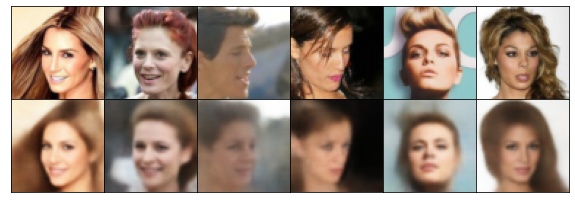

In [13]:
# load test data
test_ds = tf.data.Dataset.from_tensor_slices(data[:6])
test_ds = test_ds.map(parse_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(6).prefetch(buffer_size=AUTOTUNE)
test_batch = next(iter(test_ds))

# Reconstructed images
encoded_data  = vae.encoder.predict(test_ds)
decoded_data  = vae.decoder.predict(encoded_data[0])
plot_reconstructed(test_batch.numpy(),decoded_data)

Comme vous pouvez le constater, il à créé des deepfakes avec succès, mais la qualité est plus ou moins au rendez-vous. Le problème majeur lié à ce type de réseau neuronal est lié au fait que les photos générées ont un flou plus ou moins important. C'est intrinsèque aux auto-encodeurs variationels, puisqu'il s'agit du bruit créé par l'encodeur et le décodeur lors de la manipulation de l'image.

En termes de performances, nous avons donc un modèle créé en 12.6 heures, avec un résultat peu convaincant à première vue, mais il s'agit d'un bon début !